In [1]:
#load libraries
library(tidyverse)
library(repr)
library(tidymodels)
library(ggplot2)
library(gridExtra)
library(stringr)

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
#using the read_csv function to load data from web
tennis <- read_csv("https://drive.google.com/uc?export=download&id=1_MECmUXZuuILYeEOfonSGqodW6qVdhsS")

New names:
• `` -> `...1`
Rows: 500 Columns: 38
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (25): Age, Country, Plays, Wikipedia, Current Rank, Best Rank, Name, Bac...
dbl (13): ...1, Turned Pro, Seasons, Titles, Best Season, Retired, Masters, ...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
tennis_data <- tennis |>
  select(Age, Plays, 'Current Rank') |>
map_df(~sum(is.na(.)))
names(tennis_data) <- c("Age", "Plays", "Current_rank")
tennis_data

Age,Plays,Current_rank
<int>,<int>,<int>
1,47,5


In [4]:
tennis_data <- tennis |>
select(Age, Plays, 'Current Rank') 
names(tennis_data) <- c("Age", "Plays", "Current_rank")
tennis_data <- tennis_data |>
    mutate(handedness = case_when(
    Plays == "Left-handed" ~ "Left-handed",
    Plays == "Right-handed" ~ "Right-handed",
    TRUE ~ NA_character_
  )) |>
  mutate(handedness = as_factor(handedness)) %>%
  select(handedness, Age, Current_rank)
head(tennis_data)

handedness,Age,Current_rank
<fct>,<chr>,<chr>
Right-handed,26 (25-04-1993),378 (97)
Left-handed,18 (22-12-2001),326 (119)
Right-handed,32 (03-11-1987),178 (280)
Right-handed,21 (29-05-1998),236 (199)
Right-handed,27 (21-10-1992),183 (273)
Right-handed,22 (11-02-1997),31 (1398)


In [41]:
tennis_data <- tennis_data |>
select(handedness, Age, Current_rank) %>%
mutate(across(Age: Current_rank, function(col) {str_extract(col, "^[^ ]+")}))|>
                mutate(Age = as.numeric(Age))|>
                mutate(Current_rank = as.numeric(Current_rank))|>
                mutate(across(handedness, as.factor)) |>
  filter(!is.na(handedness) & !is.na(Age) & !is.na(Current_rank))
head(tennis_data)

handedness,Age,Current_rank
<fct>,<dbl>,<dbl>
Right-handed,26,378
Left-handed,18,326
Right-handed,32,178
Right-handed,21,236
Right-handed,27,183
Right-handed,22,31


In [42]:
set.seed(999)
tennis_split <- initial_split(tennis_data, prop = 0.75, strata = handedness)  
tennis_train <- training(tennis_split)   
tennis_test <- testing(tennis_split)
glimpse(tennis_train)
glimpse(tennis_test)

Rows: 338
Columns: 3
$ handedness   <fct> Left-handed, Left-handed, Left-handed, Left-handed, Left-…
$ Age          <dbl> 18, 23, 20, 21, 33, 27, 20, 32, 27, 28, 31, 29, 20, 25, 1…
$ Current_rank <dbl> 326, 431, 331, 43, 1, 140, 70, 42, 222, 312, 455, 76, 13,…
Rows: 114
Columns: 3
$ handedness   <fct> Right-handed, Right-handed, Right-handed, Right-handed, R…
$ Age          <dbl> 26, 32, 21, 28, 22, 30, 30, 21, 29, 27, 28, 26, 34, 27, 2…
$ Current_rank <dbl> 378, 178, 236, 148, 133, 105, 123, 388, 27, 384, 314, 374…


In [43]:
set.seed(999)
tennis_summary_avg <- tennis_train %>%
  group_by(handedness) %>%
  summarize(
    avg_age = mean(Age),
    avg_current_rank = mean(Current_rank)
  )

tennis_summary_avg

tennis_summary_sd <- tennis_train %>%
  group_by(handedness) %>%
  summarize(
    sd_age = sd(Age),
    sd_current_rank = sd(Current_rank)
  )

tennis_summary_sd

handedness,avg_age,avg_current_rank
<fct>,<dbl>,<dbl>
Right-handed,26.45548,232.3459
Left-handed,26.50000,230.7391


handedness,sd_age,sd_current_rank
<fct>,<dbl>,<dbl>
Right-handed,4.528042,144.1600
Left-handed,4.726991,148.7444


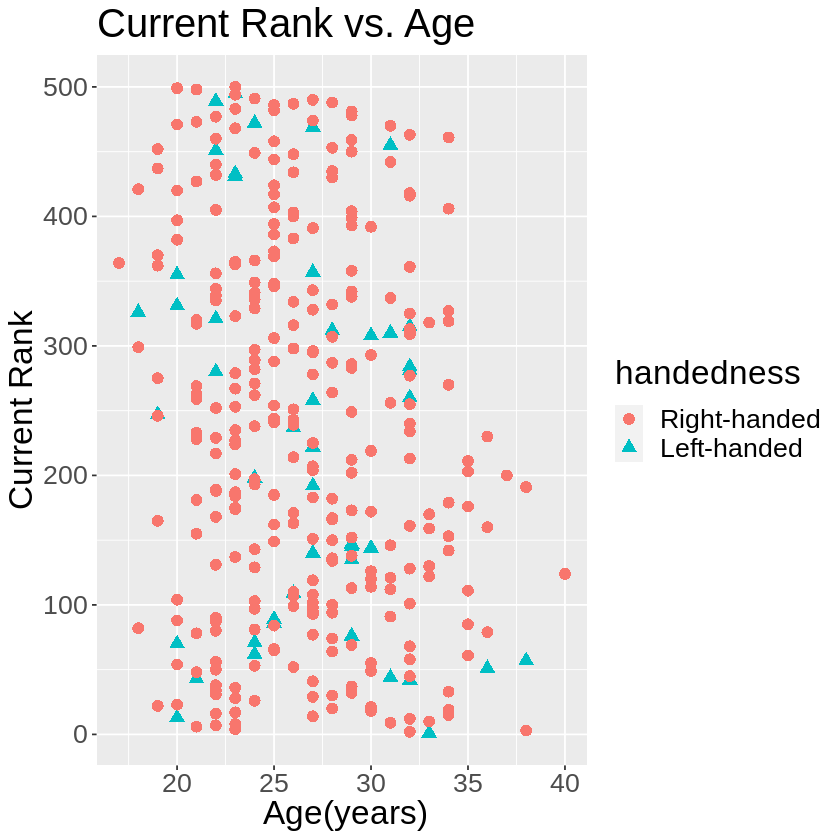

In [44]:
handedness_age_vs_rank <- tennis_train|>
    filter(handedness != "NA") |>
    ggplot(aes(x = Age, y = Current_rank, 
            color = handedness,shape = handedness)) +
  geom_point(alpha = 1, size = 3) +
  labs(x = " Age(years)", y = "Current Rank") +
  ggtitle("Current Rank vs. Age") +
      theme(text = element_text(size = 20)) 
handedness_age_vs_rank

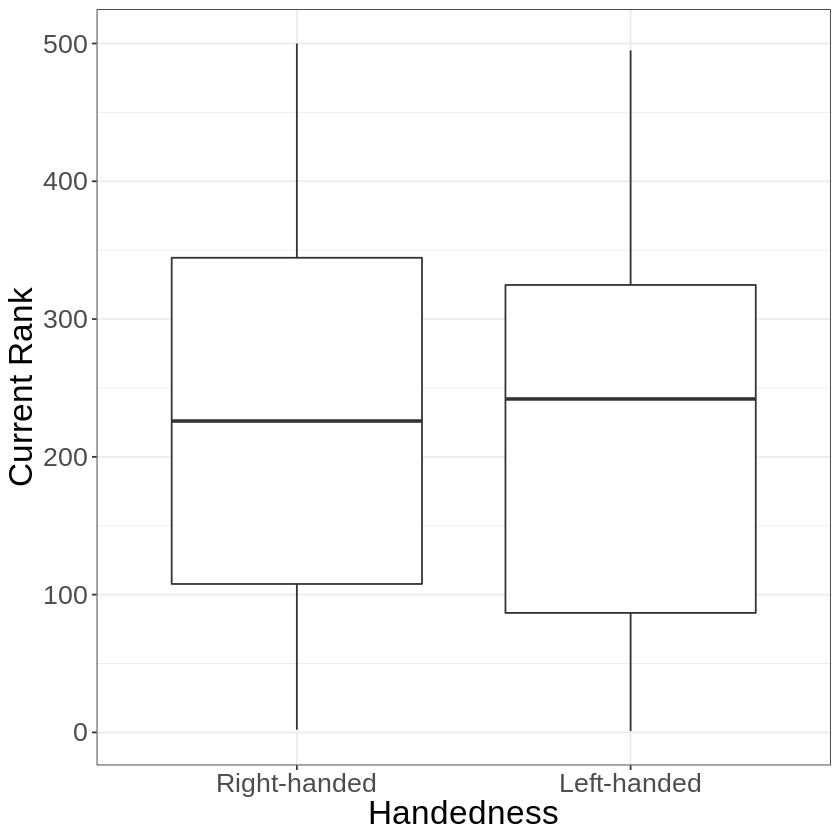

In [45]:
set.seed(999)
current_rank_plot <- ggplot(tennis_train, aes(x = handedness, y = Current_rank)) +
  geom_boxplot() +
  xlab("Handedness") +
  ylab("Current Rank") +
  theme_bw() +
  theme(text = element_text(size = 20))

current_rank_plot

In [46]:
set.seed(999)
tennis_proportions <- tennis_train |>
                      group_by(handedness) |>
                      summarize(n = n()) |>
                      mutate(percent = 100*n/nrow(tennis_train))

tennis_proportions

handedness,n,percent
<fct>,<int>,<dbl>
Right-handed,292,86.39053
Left-handed,46,13.60947


In [47]:
set.seed(999) 
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

tennis_recipe <- recipe(handedness ~., data = tennis_train) |>
  step_scale(all_predictors()) |>
  step_center(all_predictors())

tennis_vfold <- vfold_cv(tennis_train, v = 10, strata = handedness)

In [48]:
set.seed(999) 

knn_results <- workflow() |>
                 add_recipe(tennis_recipe) |>
                 add_model(knn_spec) |>
                 tune_grid(resamples = tennis_vfold, grid = 10) |>
                 collect_metrics()

accuracies <- knn_results |>
                 filter(.metric == 'accuracy')
accuracies
 

neighbors,.metric,.estimator,mean,n,std_err,.config
<int>,<chr>,<chr>,<dbl>,<int>,<dbl>,<chr>
2,accuracy,binary,0.7659715,10,0.017454338,Preprocessor1_Model01
3,accuracy,binary,0.8287217,10,0.012633975,Preprocessor1_Model02
4,accuracy,binary,0.8287217,10,0.012633975,Preprocessor1_Model03
6,accuracy,binary,0.8344309,10,0.008701666,Preprocessor1_Model04
7,accuracy,binary,0.8522613,10,0.005625132,Preprocessor1_Model05
8,accuracy,binary,0.8522613,10,0.005625132,Preprocessor1_Model06
10,accuracy,binary,0.8641202,10,0.004024663,Preprocessor1_Model07
12,accuracy,binary,0.8612631,10,0.005365746,Preprocessor1_Model08
13,accuracy,binary,0.8641202,10,0.004024663,Preprocessor1_Model09


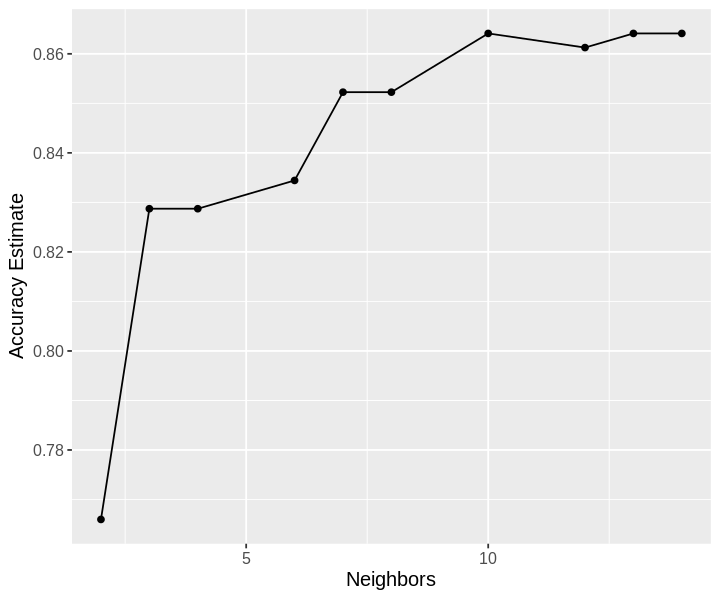

In [49]:
set.seed(999) 
options(repr.plot.height = 5, repr.plot.width = 6)
accuracy_vs_k <- ggplot(accuracies, aes(x = neighbors, y = mean)) +
                  geom_point() +
                  geom_line() +
                  labs(x = 'Neighbors', y = 'Accuracy Estimate') +
                  theme(text = element_text(size = 12))

accuracy_vs_k

In [50]:
knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 18) |>
  set_engine("kknn") |>
  set_mode("classification")

knn_fit <- workflow() |>
             add_recipe(tennis_recipe) |>
             add_model(knn_spec) |>
            fit(data = tennis_train)
knn_fit

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(18,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.1360947
Best kernel: rectangular
Best k: 18

In [51]:
set.seed(9999) 

# your code here
tennis_predictions <- predict(knn_fit, tennis_test) |>
bind_cols(tennis_test)
tennis_metrics <- tennis_predictions |>
         metrics(truth = handedness, estimate = .pred_class) |>
  filter(.metric == "accuracy")
tennis_mat <- tennis_predictions |>
         conf_mat(truth = handedness, estimate = .pred_class)
head(tennis_predictions)
tennis_metrics
tennis_mat

.pred_class,handedness,Age,Current_rank
<fct>,<fct>,<dbl>,<dbl>
Right-handed,Right-handed,26,378
Right-handed,Right-handed,32,178
Right-handed,Right-handed,21,236
Right-handed,Right-handed,28,148
Right-handed,Right-handed,22,133
Right-handed,Right-handed,30,105


.metric,.estimator,.estimate
<chr>,<chr>,<dbl>
accuracy,binary,0.8596491


              Truth
Prediction     Right-handed Left-handed
  Right-handed           98          16
  Left-handed             0           0